<a href="https://colab.research.google.com/github/ArturBorisov01/Algoritm-Brandes/blob/master/PM2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import matplotlib.pyplot as plt
import csv
import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
dates = []
values = []

with open('/content/drive/MyDrive/практикум РР/tashkent-us embassy-air-quality.csv', 'r') as file:
  reader = csv.reader(file)
  next(reader)
  for row in reader:
           date_str = row[0]
           date = datetime.datetime.strptime(date_str, '%Y/%m/%d').date()  # Convert date string to datetime object
           dates.append(date)
           try:
            value = row[1].strip()  # Remove leading/trailing whitespace
            if value == '':  # Check if the cell is empty
                values.append(0.0)  # Replace empty cell with 0.0
            else:
                values.append(float(value))  # Convert to float if not empty

           except ValueError:
            print(f"Skipping invalid value in row: {row}")  # Handle other errors
            values.append(0.0) # Replace invalid value with 0.0

data = list(zip(dates, values))  # Combine dates and values into a list of tuples
data.sort(key=lambda item: item[0])  # Sort by the first element of each tuple (date)
dates, values = zip(*data)  # Unpack the sorted data back into separate lists

#show first date with value (for sync with wather further)
for i in range(len(values)):
    if values[i] != 0.0:
        print(dates[i])
        break

# Find the last date with a non-zero value
last_date_with_value = None
for i in range(len(values) - 1, -1, -1):
    if values[i] != 0.0:
        last_date_with_value = dates[i]
        break

if last_date_with_value:
    print(last_date_with_value)
else:
    print("No dates with values found.")

2018-11-26
2025-01-24




---
Декомпозиция данных о загрязнении (тренд, сезонгость, шум)
---

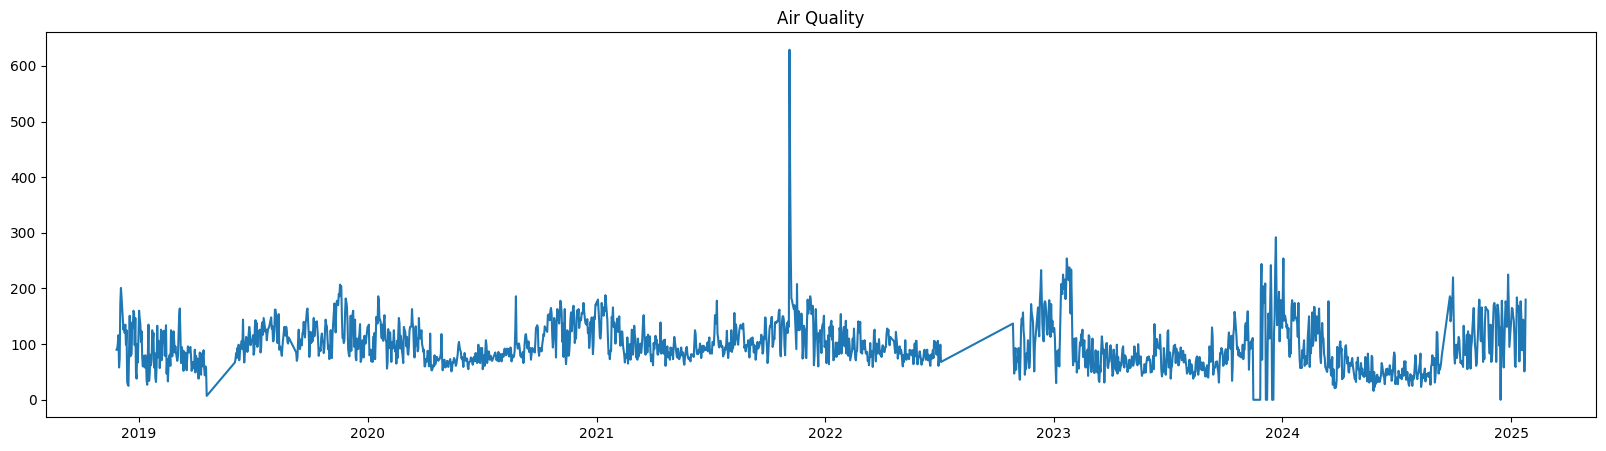

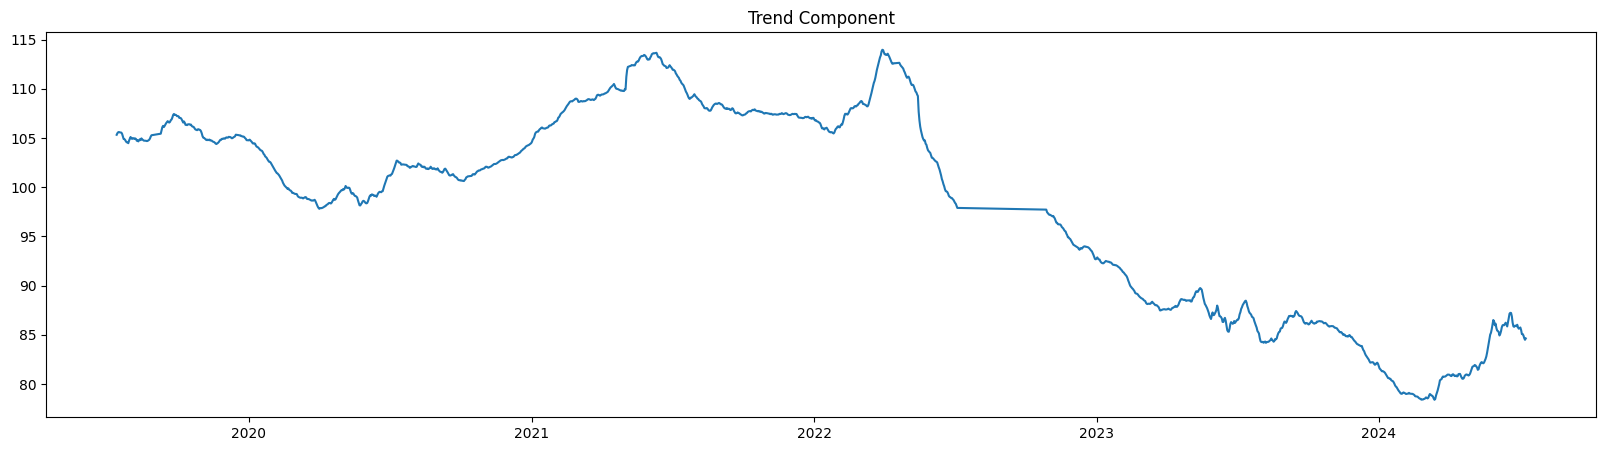

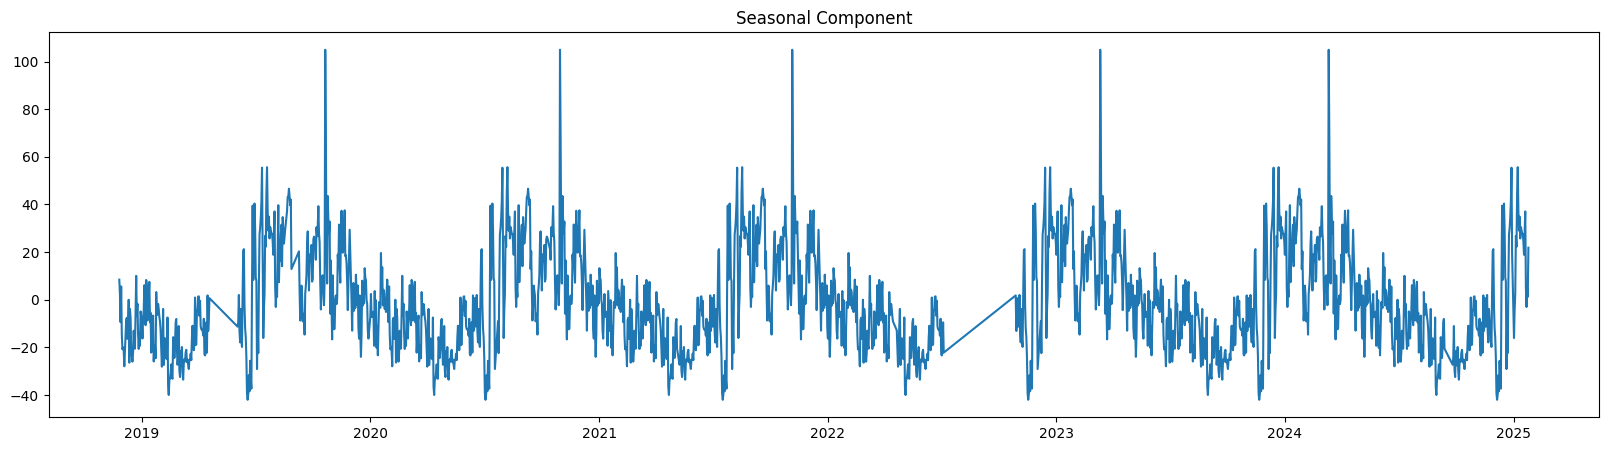

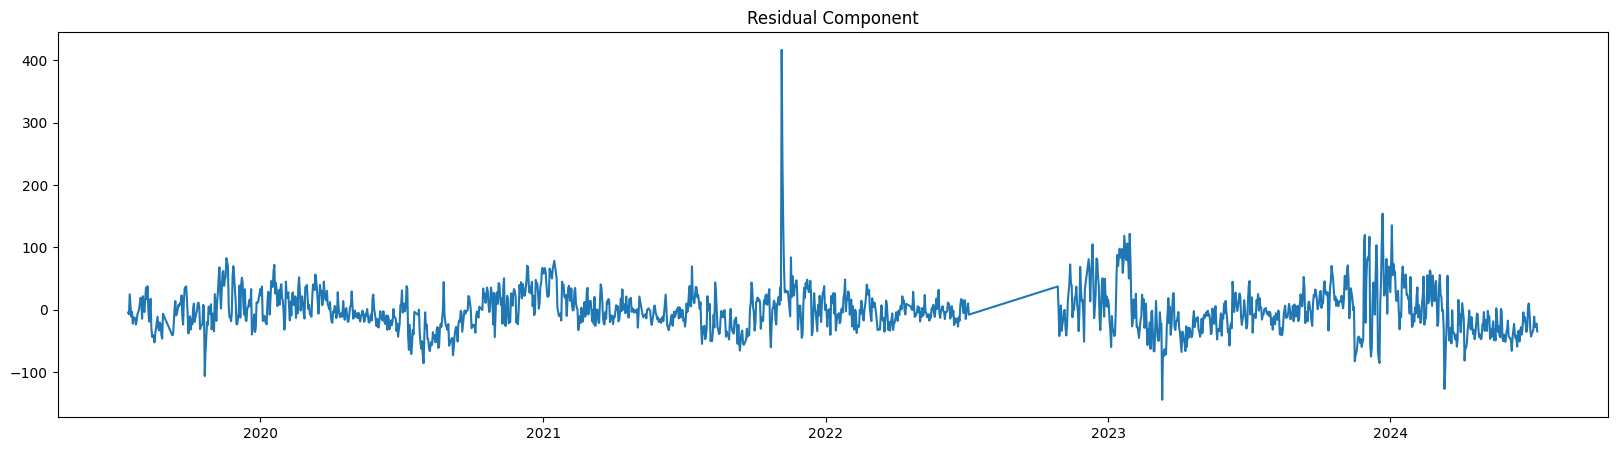

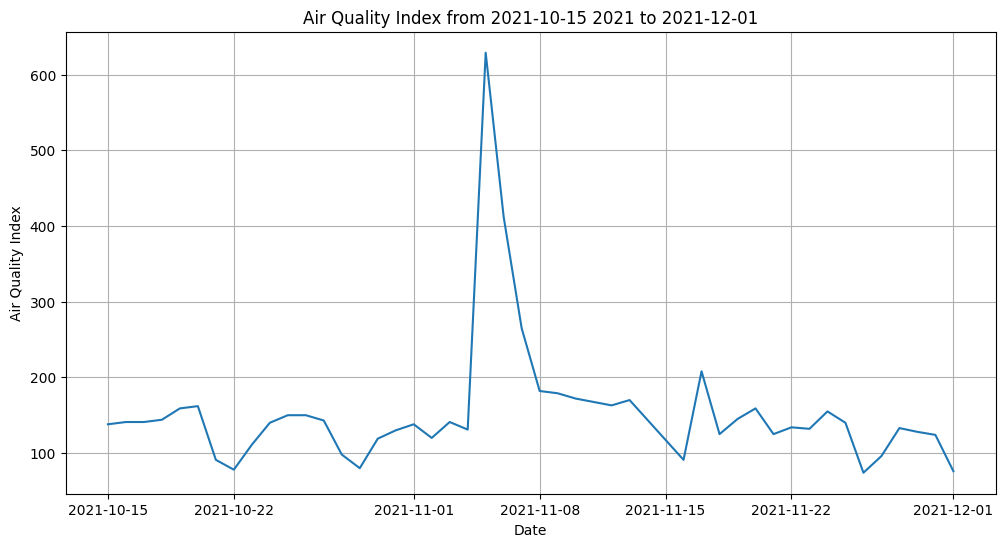

The date with the maximum value is: 2021-11-05 00:00:00


In [ ]:
# Convert dates to a pandas DateTimeIndex
dates = pd.to_datetime(dates)

# Create a pandas Series with your data
series = pd.Series(values, index=dates)

# Perform seasonal decomposition
result = seasonal_decompose(series, model='additive', period=365)  # Assuming yearly seasonality

# # Plot the decomposed components
# result.plot()

plt.figure(figsize=(20, 5))
plt.plot(series, label="индекс загрязнения")
plt.title("Air Quality") # Add title for the trend chart

# Выделяем трендовую компоненту
trend = result.trend
# Строим график трендовой компоненты
plt.figure(figsize=(20, 5))
plt.plot(trend, label="трендовая компонента")
plt.title("Trend Component") # Add title for the trend chart


# Выделяем сезонную компоненту
seasonal = result.seasonal
# Строим график сезонной компоненты
plt.figure(figsize=(20, 5))
plt.plot(seasonal, label="Сезонная компонента")
plt.title("Seasonal Component") # Add title for the seasonal chart

# Выделяем сезонную компоненту
resid = result.resid
# Строим график остаточной компоненты
plt.figure(figsize=(20, 5))
plt.plot(resid)
plt.title("Residual Component") # Add title for the residual chart


plt.show()

# Create a DataFrame for the trend data
trend_df = pd.DataFrame(trend, columns=['Trend'])

# Export to CSV
trend_df.to_csv('trend_data.csv', index=True)

# ... (Your existing code to load and process data) ...

# Assuming 'series' is your pandas Series with dates as index
start_date = pd.to_datetime('2021-10-15')
end_date = pd.to_datetime('2021-12-01')

filtered_series = series[(series.index >= start_date) & (series.index <= end_date)]

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(filtered_series)
plt.title('Air Quality Index from 2021-10-15 2021 to 2021-12-01')
plt.xlabel('Date')
plt.ylabel('Air Quality Index')
plt.grid(True)  # Add grid for better visualization
plt.show()

max_value_date = series.idxmax()

print(f"The date with the maximum value is: {max_value_date}")

In [ ]:
# ANOVA (ANalysis Of VAriance) — Дисперсионный анализ

import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm # Import anova_lm directly

# Perform ANOVA test on the seasonal component
seasonal_data = pd.DataFrame({'Seasonal': result.seasonal})
seasonal_data['Month'] = seasonal_data.index.month # Extract month as a factor

model = sm.ols('Seasonal ~ C(Month)', data=seasonal_data).fit()
anova_table = anova_lm(model) # Call anova_lm directly

# Print the ANOVA table
print(anova_table)

# Check the p-value for significance
p_value = anova_table['PR(>F)'].iloc[0]  # Use .iloc[0] for position

if p_value < 0.05:
    print("\nThe seasonal component is statistically significant (p < 0.05)")
else:
    print("The seasonal component is not statistically significant (p >= 0.05)")

              df         sum_sq      mean_sq          F        PR(>F)
C(Month)    11.0   87828.364706  7984.396791  19.206316  3.856307e-37
Residual  2019.0  839333.098004   415.717235        NaN           NaN

The seasonal component is statistically significant (p < 0.05)


In [ ]:
import matplotlib.pyplot as plt
import csv
import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats # Import stats for Shapiro-Wilk test


# --- Shapiro-Wilk Test ---
# Apply the Shapiro-Wilk test to the residual component
shapiro_test = stats.shapiro(result.resid.dropna())  # dropna() to handle NaNs

# Extract the test statistic and p-value
W_statistic, p_value = shapiro_test

# Print the results
print("Shapiro-Wilk Test Results:")
print(f"W-statistic: {W_statistic}")
print(f"p-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value > alpha:
    print("\nThe residuals appear to be normally distributed (fail to reject H0)")
else:
    print("\nThe residuals do not appear to be normally distributed (reject H0)")

Shapiro-Wilk Test Results:
W-statistic: 0.9255085845093081
p-value: 5.54332474131781e-28

The residuals do not appear to be normally distributed (reject H0)




---

Добавление и обработка данных о погоде:
-выделение верхней и нижней грани (данные где есть тепература)
-каждый час -> среднее за день
---

In [ ]:
import matplotlib.pyplot as plt
import csv
import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Updated file path
file_path = '/content/drive/MyDrive/практикум РР/dataexport_20250130T031948.csv'

dates = []
temperatures = []
humidity = []
wind_speed = []
wind_direction = []

with open(file_path, 'r') as file:
    reader = csv.reader(file)
    for i in range(10):  # Skip the first 10 rows
        next(reader)
    for row in reader:
        date_str = row[0]
        try:
            date = datetime.datetime.strptime(date_str, '%Y%m%dT%H%M')
            dates.append(date)

            # Handling empty cells and converting to float:
            temperatures.append(float(row[1]) if row[1] else np.nan)
            humidity.append(float(row[2]) if row[2] else np.nan)
            wind_speed.append(float(row[3]) if row[3] else np.nan)
            wind_direction.append(float(row[4]) if row[4] else np.nan)

        except (ValueError, IndexError):
            print(f"Skipping invalid row: {row}")

# Create a DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Temperature': temperatures,
    'Relative Humidity': humidity,
    'Wind Speed': wind_speed,
    'Wind Direction': wind_direction
})

# Set 'Date' as the index
df = df.set_index('Date')

# Group by date (without time) and calculate the mean
daily_averages = df.groupby(df.index.date).mean()

daily_averages

# Filter out rows with missing temperature values
daily_averages_with_temp = daily_averages.dropna(subset=['Temperature'])

# Get the first and last dates with temperature values
first_date = daily_averages_with_temp.index.min()
last_date = daily_averages_with_temp.index.max()

# Get the corresponding temperature values
first_temp = daily_averages_with_temp.loc[first_date, 'Temperature']
last_temp = daily_averages_with_temp.loc[last_date, 'Temperature']

# Print the results
print(f"First date with temperature value: {first_date}, Temperature: {first_temp}")
print(f"Last date with temperature value: {last_date}, Temperature: {last_temp}")


First date with temperature value: 2018-11-26, Temperature: 4.7710787
Last date with temperature value: 2025-01-23, Temperature: 5.7052452874999995




---


Корреляция между погодой и загрязнением воздуха
---

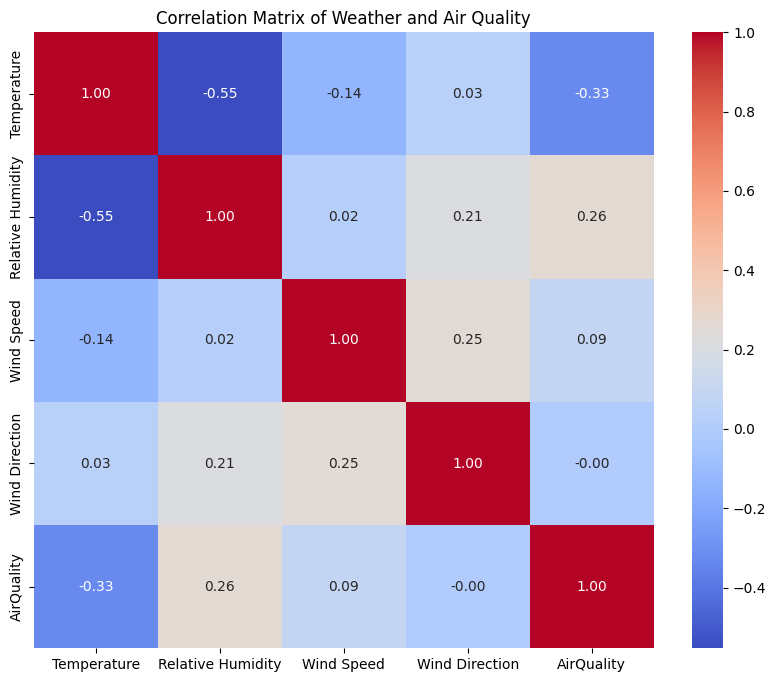

In [ ]:
# Merge the two datasets based on the date
merged_data = pd.merge(daily_averages, series.to_frame(name='AirQuality'), left_index=True, right_index=True, how='inner')

# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Print the correlation matrix
# print(correlation_matrix)

# You can also visualize the correlation matrix using a heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather and Air Quality')

plt.show()



---
Корреляция с шагом +3 (выявление лагов)
---

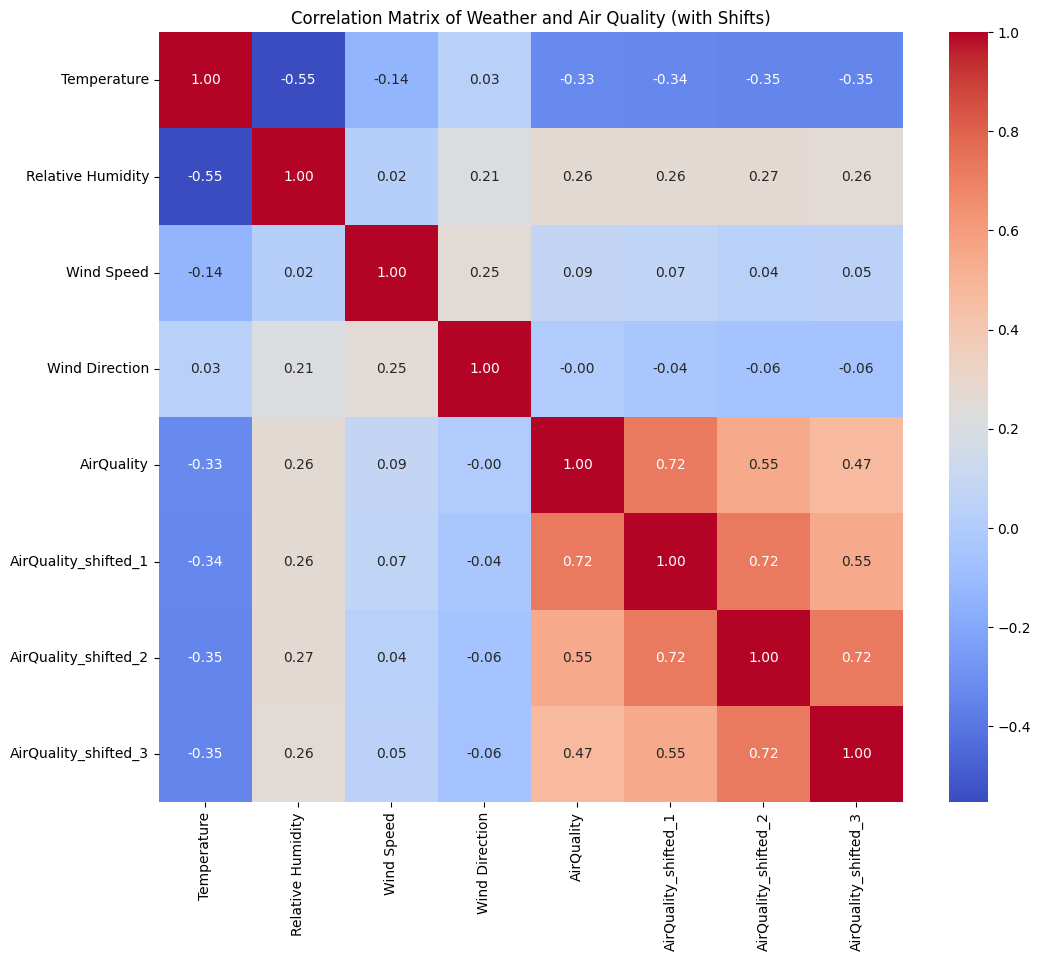

In [ ]:
import matplotlib.pyplot as plt
import csv
import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


# Function to calculate correlation with shift
def calculate_correlation_with_shift(data, shift):
    shifted_data = data['AirQuality'].shift(shift)
    shifted_data.name = f'AirQuality_shifted_{shift}'

    # Merge shifted data with weather data
    merged_data = pd.merge(
        data[['Temperature', 'Relative Humidity', 'Wind Speed', 'Wind Direction']],
        shifted_data,
        left_index=True,
        right_index=True,
        how='inner'
    )

    # Calculate and print correlation
    correlation = merged_data.corr()
    print(f"\nCorrelation with shift of {shift} day(s):")
    print(correlation.loc[[f'AirQuality_shifted_{shift}'], ['Temperature', 'Relative Humidity', 'Wind Speed', 'Wind Direction']])

# Merge the two datasets based on the date
merged_data = pd.merge(daily_averages, series.to_frame(name='AirQuality'), left_index=True, right_index=True, how='inner')

# Calculate correlations with shifts
for shift in [1, 2, 3]:
    shifted_data = merged_data['AirQuality'].shift(shift)
    shifted_data.name = f'AirQuality_shifted_{shift}'
    merged_data = pd.concat([merged_data, shifted_data], axis=1)

# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Draw the correlation matrix heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather and Air Quality (with Shifts)')
plt.show()




---
Корреляция с шагов -3 +3
---

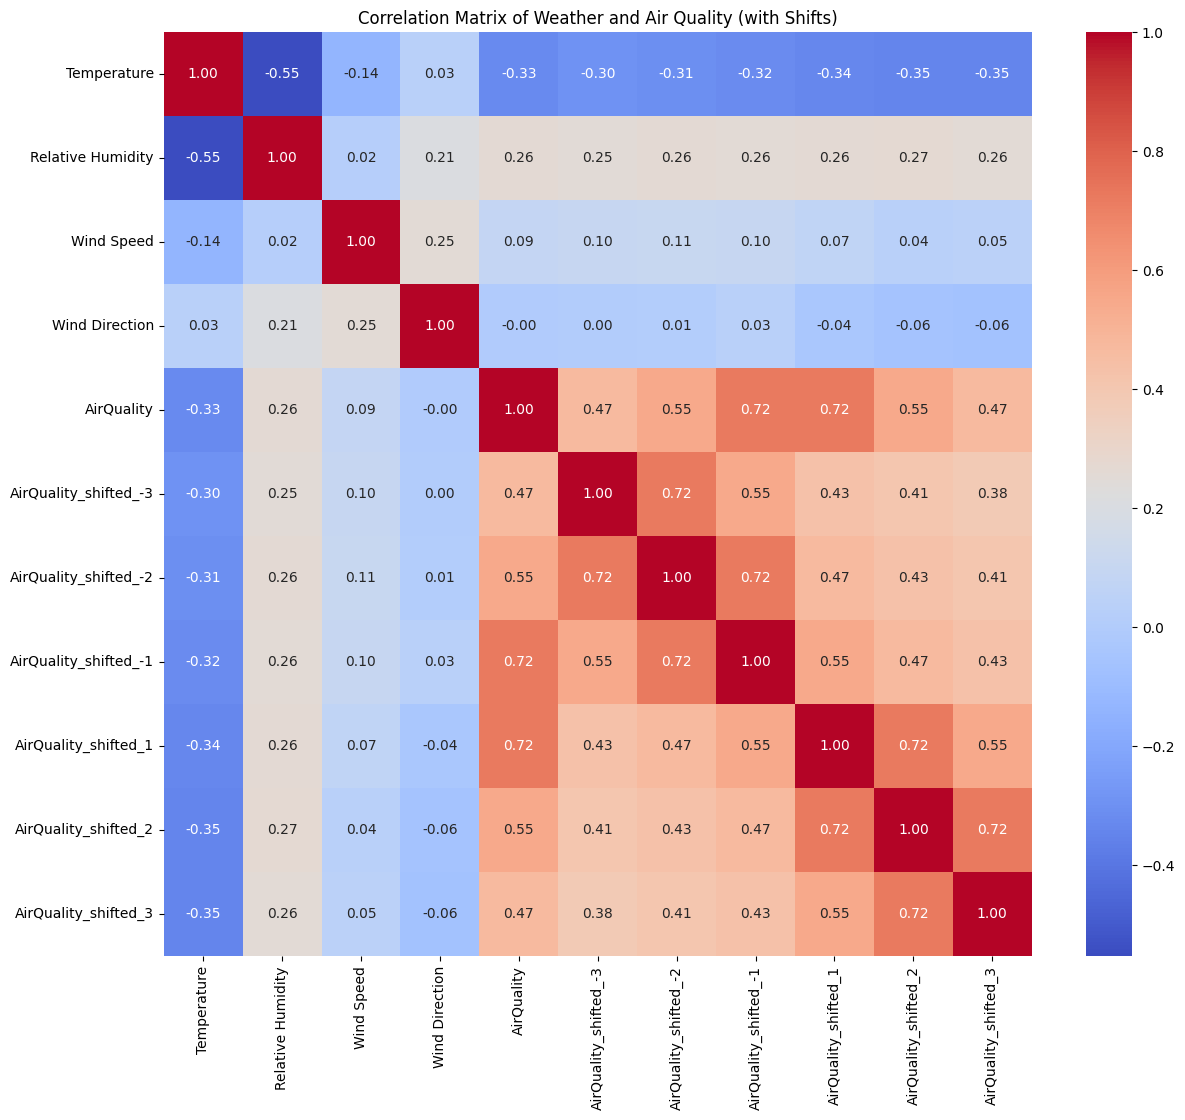

In [ ]:
import matplotlib.pyplot as plt
import csv
import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# Function to calculate correlation with shift (modified)
def calculate_correlation_with_shift(data, shift):
    shifted_data = data['AirQuality'].shift(shift)
    shifted_data.name = f'AirQuality_shifted_{shift}'

    # Merge shifted data with weather data
    merged_data = pd.merge(
        data[['Temperature', 'Relative Humidity', 'Wind Speed', 'Wind Direction']],
        shifted_data,
        left_index=True,
        right_index=True,
        how='inner'
    )

    # Calculate and print correlation
    correlation = merged_data.corr()
    # print(f"\nCorrelation with shift of {shift} day(s):")
    # print(correlation.loc[[f'AirQuality_shifted_{shift}'], ['Temperature', 'Relative Humidity', 'Wind Speed', 'Wind Direction']])

# Merge the two datasets based on the date
merged_data = pd.merge(daily_averages, series.to_frame(name='AirQuality'), left_index=True, right_index=True, how='inner')

# Calculate correlations with shifts (including negative shifts)
for shift in [-3, -2, -1, 1, 2, 3]:  # Added negative shifts
    calculate_correlation_with_shift(merged_data, shift)

    shifted_data = merged_data['AirQuality'].shift(shift)
    shifted_data.name = f'AirQuality_shifted_{shift}'
    merged_data = pd.concat([merged_data, shifted_data], axis=1)


# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Draw the correlation matrix heatmap
plt.figure(figsize=(14, 12))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather and Air Quality (with Shifts)')
plt.show()



---
Краткосрочные данные
---



                   Temperature  Relative Humidity  Wind Speed  Wind Direction  \
Temperature           1.000000          -0.553105   -0.135686        0.029898   
Relative Humidity    -0.553105           1.000000    0.022977        0.210941   
Wind Speed           -0.135686           0.022977    1.000000        0.254632   
Wind Direction        0.029898           0.210941    0.254632        1.000000   
AirQuality_resid     -0.318247           0.223387    0.121716        0.007336   

                   AirQuality_resid  
Temperature               -0.318247  
Relative Humidity          0.223387  
Wind Speed                 0.121716  
Wind Direction             0.007336  
AirQuality_resid           1.000000  


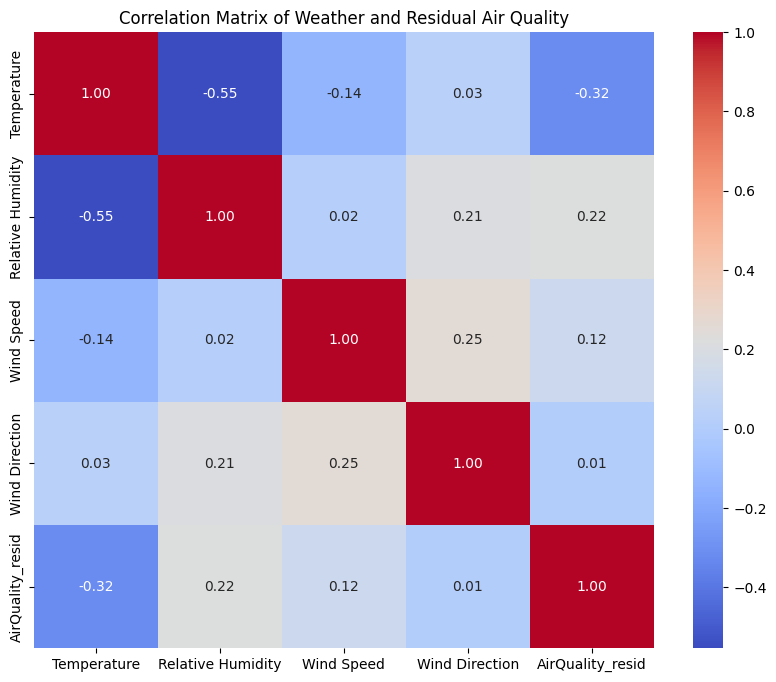

In [ ]:
import matplotlib.pyplot as plt
import csv
import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


# Perform seasonal decomposition
result = seasonal_decompose(series, model='additive', period=365)

# Extract the residual component
resid = result.resid

# Merge the residual component with weather data
merged_data = pd.merge(daily_averages, resid.to_frame(name='AirQuality_resid'), left_index=True, right_index=True, how='inner')

# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Print the correlation matrix
print(correlation_matrix)

# Draw the correlation matrix heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather and Residual Air Quality')
plt.show()



---
Долгосрочные данные
---

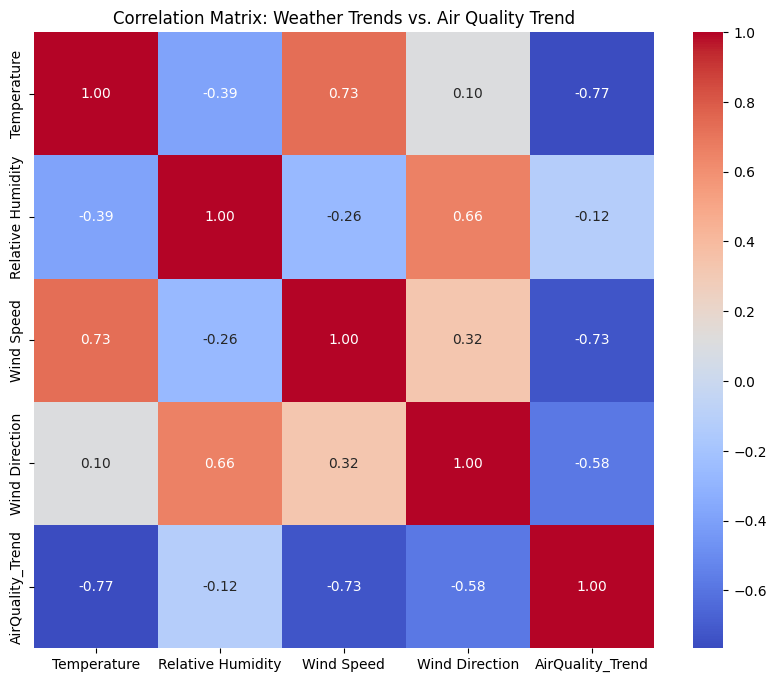

In [ ]:
import matplotlib.pyplot as plt
import csv
import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


# 1. Calculate Trends of Weather Parameters
weather_trends = daily_averages.apply(lambda x: seasonal_decompose(x.ffill(), model='additive', period=365).trend)

# 2. Calculate Trend of Air Quality
air_quality_trend = seasonal_decompose(series, model='additive', period=365).trend

# 3. Merge Trend Data
merged_trends = pd.merge(weather_trends, air_quality_trend.to_frame(name='AirQuality_Trend'), left_index=True, right_index=True, how='inner')

# 4. Calculate Correlation Matrix
correlation_matrix = merged_trends.corr()

# 5. Visualize Correlation Matrix (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Weather Trends vs. Air Quality Trend')
plt.show()

# Print the correlation matrix
# print(correlation_matrix)

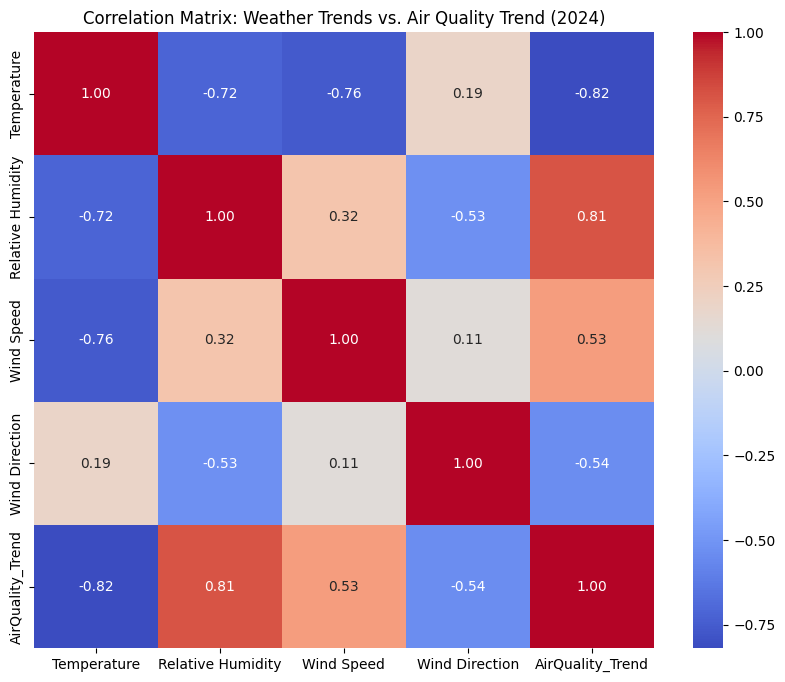

                   Temperature  Relative Humidity  Wind Speed  Wind Direction  \
Temperature           1.000000          -0.718442   -0.758477        0.191340   
Relative Humidity    -0.718442           1.000000    0.315798       -0.526904   
Wind Speed           -0.758477           0.315798    1.000000        0.114493   
Wind Direction        0.191340          -0.526904    0.114493        1.000000   
AirQuality_Trend     -0.819734           0.814024    0.529576       -0.537328   

                   AirQuality_Trend  
Temperature               -0.819734  
Relative Humidity          0.814024  
Wind Speed                 0.529576  
Wind Direction            -0.537328  
AirQuality_Trend           1.000000  


In [ ]:
import matplotlib.pyplot as plt
import csv
import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# 1. Filter data for 2024
# Convert the index to DateTimeIndex if it's not already
daily_averages.index = pd.to_datetime(daily_averages.index)
daily_averages_2024 = daily_averages[daily_averages.index.year == 2024]
series_2024 = series[series.index.year == 2024]

# 2. Calculate Trends of Weather Parameters for 2024
# Assuming a monthly seasonality for 2024 data (period=30 or 31)
weather_trends_2024 = daily_averages_2024.apply(lambda x: seasonal_decompose(x.ffill(), model='additive', period=30).trend) # Changed period to 30

# 3. Calculate Trend of Air Quality for 2024
# Assuming a monthly seasonality for 2024 data (period=30 or 31)
air_quality_trend_2024 = seasonal_decompose(series_2024, model='additive', period=30).trend # Changed period to 30

# 4. Merge Trend Data for 2024
merged_trends_2024 = pd.merge(weather_trends_2024, air_quality_trend_2024.to_frame(name='AirQuality_Trend'), left_index=True, right_index=True, how='inner')

# 5. Calculate Correlation Matrix for 2024
correlation_matrix_2024 = merged_trends_2024.corr()

# 6. Visualize Correlation Matrix (Heatmap) for 2024
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_2024, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Weather Trends vs. Air Quality Trend (2024)')
plt.show()

# Print the correlation matrix for 2024
print(correlation_matrix_2024)